# Fraud Detection - Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, average_precision_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Configure MLflow to use Docker MLflow server
mlflow.set_tracking_uri("http://localhost:5500")
mlflow.set_experiment("Real-Time Fraud Detection")
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

MLflow Tracking URI: http://localhost:5500


## Load Feature-Engineered Data

In [9]:
# Load pre-split feature-engineered datasets
train_df = pd.read_csv("../DATA/feature_engineered/train.csv")
val_df = pd.read_csv("../DATA/feature_engineered/val.csv")
test_df = pd.read_csv("../DATA/feature_engineered/test.csv")

print(f"Train data shape: {train_df.shape}")
print(f"Val data shape: {val_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Display first few rows
print("\nTrain data preview:")
train_df.head()

Train data shape: (3733016, 38)
Val data shape: (424906, 38)
Test data shape: (842075, 38)

Train data preview:


,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,time_since_last_transaction,spending_deviation_score,...,receiver_degree,sender_total_transaction,receiver_total_transaction,sender_avg_amount,sender_std_amount,sender_fraud_transaction,receiver_fraud_transaction,sender_fraud_percentage,receiver_fraud_percentage,deviation_squared
0,158871,89037,12.25,2,1,1,0,0,-7559.966086,-0.32,...,4,5,4,225.752000,194.592575,0,0,0.0,0.00,0.1024
1,376957,4992,1347.27,0,6,5,1,0,1.525799,-0.68,...,4,9,4,432.798889,503.598960,0,0,0.0,0.00,0.4624
2,727819,491398,20.79,1,6,6,3,0,-4568.663237,0.14,...,6,5,6,170.508000,189.434766,0,1,0.0,16.67,0.0196
3,545869,270273,740.73,0,7,0,1,0,1.525799,-2.09,...,4,5,4,445.014000,413.808428,0,0,0.0,0.00,4.3681
4,880977,66830,228.67,0,1,1,1,0,-48.738700,0.16,...,6,5,6,661.024000,649.946021,0,0,0.0,0.00,0.0256


In [10]:
# Check for missing values
print("Train data missing values:")
print(train_df.isna().sum().sum())
print("\nVal data missing values:")
print(val_df.isna().sum().sum())
print("\nTest data missing values:")
print(test_df.isna().sum().sum())

Train data missing values:
0

Val data missing values:
0

Test data missing values:
0


## Data Balancing

In [11]:
# Check class distribution in training data
print("Training data class distribution:")
print(train_df['is_fraud'].value_counts())
print(f"\nFraud rate: {train_df['is_fraud'].mean():.4f}")

print("\n" + "="*50)
print("\nValidation data class distribution:")
print(val_df['is_fraud'].value_counts())
print(f"\nFraud rate: {val_df['is_fraud'].mean():.4f}")

print("\n" + "="*50)
print("\nTest data class distribution:")
print(test_df['is_fraud'].value_counts())
print(f"\nFraud rate: {test_df['is_fraud'].mean():.4f}")

Training data class distribution:
is_fraud
0    3599111
1     133905
Name: count, dtype: int64

Fraud rate: 0.0359


Validation data class distribution:
is_fraud
0    409575
1     15331
Name: count, dtype: int64

Fraud rate: 0.0361


Test data class distribution:
is_fraud
0    811758
1     30317
Name: count, dtype: int64

Fraud rate: 0.0360


## Prepare Features and Target

In [12]:
# Separate features and target for train, val, and test sets
X_train = train_df.drop(columns=['is_fraud'])
y_train = train_df['is_fraud']

X_val = val_df.drop(columns=['is_fraud'])
y_val = val_df['is_fraud']

X_test = test_df.drop(columns=['is_fraud'])
y_test = test_df['is_fraud']

print(f"Training features: {X_train.shape}")
print(f"Training labels: {y_train.shape}")
print(f"\nValidation features: {X_val.shape}")
print(f"Validation labels: {y_val.shape}")
print(f"\nTest features: {X_test.shape}")
print(f"Test labels: {y_test.shape}")

Training features: (3733016, 37)
Training labels: (3733016,)

Validation features: (424906, 37)
Validation labels: (424906,)

Test features: (842075, 37)
Test labels: (842075,)


In [13]:
# Check data types and features
print("Feature data types:")
print(X_train.dtypes)
print(f"\nFeature names: {list(X_train.columns)}")

Feature data types:
sender_account                   int64
receiver_account                 int64
amount                         float64
transaction_type                 int64
merchant_category                int64
location                         int64
device_used                      int64
time_since_last_transaction    float64
spending_deviation_score       float64
velocity_score                 float64
geo_anomaly_score              float64
payment_channel                  int64
ip_address                       int64
device_hash                      int64
hour                           float64
day                            float64
day_of_week                    float64
month                          float64
amount_per_velocity            float64
amount_log                     float64
amount_to_avg_ratio            float64
transaction_per_day              int64
transaction_gap                float64
is_night_transaction             int64
is_weekend                       int64
is_se

Training XGBoost model with MLflow tracking...
[14:04:44] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (3733016, 37, 138121592).
[14:04:44] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (424906, 37, 15721522).
[14:04:44] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
[14:04:45] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
[0]	validation_0-aucpr:0.84536	validation_1-aucpr:0.99898
[50]	validation_0-aucpr:0.86275	validation_1-aucpr:0.99927
[100]	validation_0-aucpr:0.86789	validation_1-aucpr:0.99950
[150]	validation_0-aucpr:0.87337	validation_1-aucpr:0.99951
[200]	validation_0-aucpr:0.87917	validation_1-aucpr:0.99951
[250]	validation_0-aucpr:0.88543	validation_1-aucpr:0.99950
[299]	validation_0-aucpr:0.89141	validation_1-aucpr:0.99949
XG

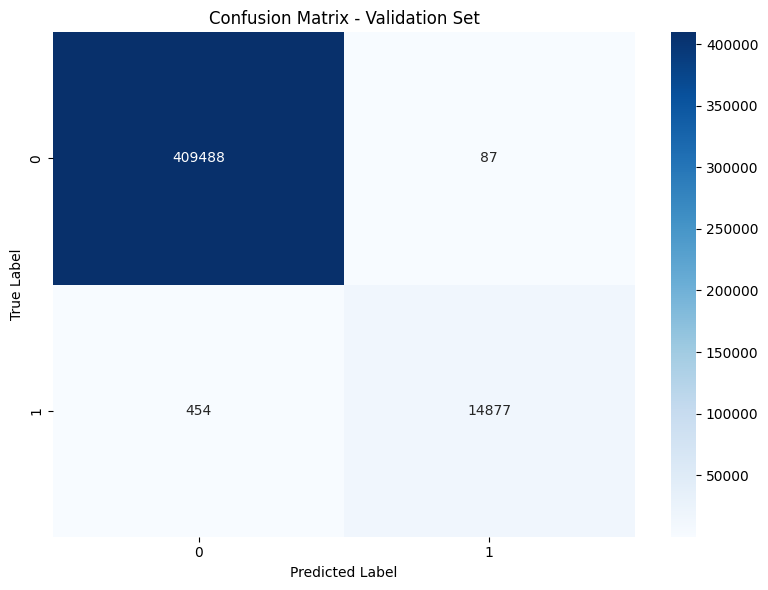


TEST SET EVALUATION
Precision: 0.9888
Recall:    0.8670
F1 Score:  0.9239
AUC-PR:    0.9964
AUC-ROC:   0.9999


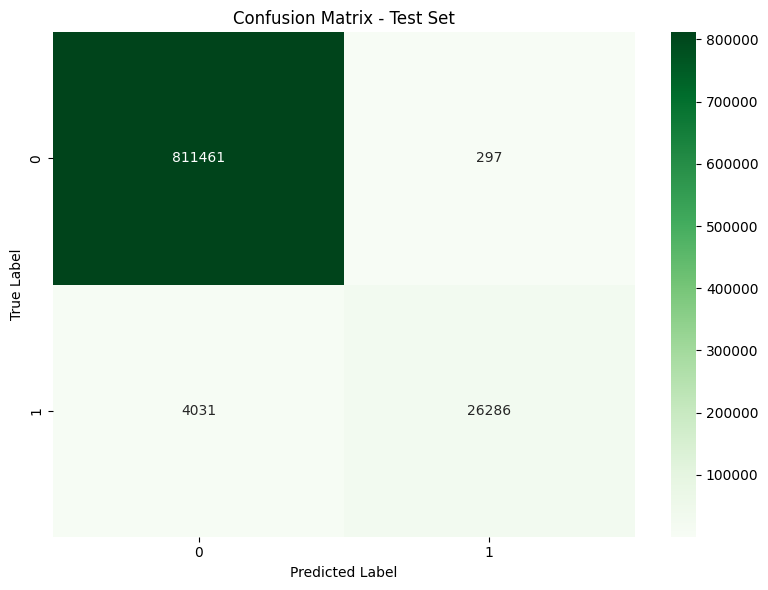


METRICS SUMMARY
Metric          Validation      Test           
------------------------------------------------------------
Precision       0.9942          0.9888         
Recall          0.9704          0.8670         
F1 Score        0.9821          0.9239         
AUC-PR          0.9995          0.9964         
AUC-ROC         1.0000          0.9999         


MLflow Run ID: ec1cb5e7e9784f0d981cda8362817565
Model saved locally to: ../models/best_fraud_detection_model.pkl
Metrics and parameters logged to MLflow (localhost:5500)
🏃 View run XGBoost_Fraud_Detection at: http://localhost:5500/#/experiments/1/runs/ec1cb5e7e9784f0d981cda8362817565
🧪 View experiment at: http://localhost:5500/#/experiments/1


In [15]:
from xgboost import XGBClassifier

# Start MLflow run to track this experiment
with mlflow.start_run(run_name="XGBoost_Fraud_Detection"):
    
    # Calculate scale_pos_weight for handling class imbalance
    scale_pos_weight = y_train[y_train == 1].count() / y_train[y_train == 0].count()
    
    # Define model hyperparameters
    params = {
        'n_estimators': 300,
        'objective': 'binary:logistic',
        'tree_method': 'hist',
        'max_depth': 12,
        'learning_rate': 0.05,
        'reg_lambda': 3.6,
        'reg_alpha': 3.6,
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'aucpr',
        'verbosity': 2,
        'subsample': 0.8,
        'device': 'cuda',
        'n_jobs': -1,
        'random_state': 36
    }
    
    # Create and train XGBoost model
    xgb_model = XGBClassifier(**params)
    
    print("Training XGBoost model with MLflow tracking...")
    eval_set = [(X_train, y_train), (X_val, y_val)]
    xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=50)
    print("XGBoost training completed!")
    
    # Import metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    # ==================== VALIDATION SET EVALUATION ====================
    print(f"\n{'='*60}")
    print("VALIDATION SET EVALUATION")
    print(f"{'='*60}")
    
    # Make predictions on validation set
    y_val_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
    y_val_pred = xgb_model.predict(X_val)
    
    # Calculate validation metrics
    val_precision = float(precision_score(y_val, y_val_pred))
    val_recall = float(recall_score(y_val, y_val_pred))
    val_f1 = float(f1_score(y_val, y_val_pred))
    val_auc_pr = float(average_precision_score(y_val, y_val_pred_proba))
    val_auc_roc = float(roc_auc_score(y_val, y_val_pred_proba))
    
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall:    {val_recall:.4f}")
    print(f"F1 Score:  {val_f1:.4f}")
    print(f"AUC-PR:    {val_auc_pr:.4f}")
    print(f"AUC-ROC:   {val_auc_roc:.4f}")
    
    # Validation confusion matrix
    cm_val = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Validation Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # ==================== TEST SET EVALUATION ====================
    print(f"\n{'='*60}")
    print("TEST SET EVALUATION")
    print(f"{'='*60}")
    
    # Make predictions on test set
    y_test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    y_test_pred = xgb_model.predict(X_test)
    
    # Calculate test metrics
    test_precision = float(precision_score(y_test, y_test_pred))
    test_recall = float(recall_score(y_test, y_test_pred))
    test_f1 = float(f1_score(y_test, y_test_pred))
    test_auc_pr = float(average_precision_score(y_test, y_test_pred_proba))
    test_auc_roc = float(roc_auc_score(y_test, y_test_pred_proba))
    
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall:    {test_recall:.4f}")
    print(f"F1 Score:  {test_f1:.4f}")
    print(f"AUC-PR:    {test_auc_pr:.4f}")
    print(f"AUC-ROC:   {test_auc_roc:.4f}")
    
    # Test confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # ==================== LOG TO MLFLOW ====================
    # Log hyperparameters
    mlflow.log_params(params)
    mlflow.log_params({
        "train_samples": len(X_train),
        "val_samples": len(X_val),
        "test_samples": len(X_test),
        "n_features": X_train.shape[1],
        "fraud_rate_train": float(y_train.mean()),
        "fraud_rate_val": float(y_val.mean()),
        "fraud_rate_test": float(y_test.mean())
    })
    
    # Log validation metrics
    mlflow.log_metrics({
        "val_precision": val_precision,
        "val_recall": val_recall,
        "val_f1_score": val_f1,
        "val_auc_pr": val_auc_pr,
        "val_auc_roc": val_auc_roc
    })
    
    # Log test metrics
    mlflow.log_metrics({
        "test_precision": test_precision,
        "test_recall": test_recall,
        "test_f1_score": test_f1,
        "test_auc_pr": test_auc_pr,
        "test_auc_roc": test_auc_roc
    })
    
    # ==================== SUMMARY ====================
    print(f"\n{'='*60}")
    print("METRICS SUMMARY")
    print(f"{'='*60}")
    print(f"{'Metric':<15} {'Validation':<15} {'Test':<15}")
    print(f"{'-'*60}")
    print(f"{'Precision':<15} {val_precision:<15.4f} {test_precision:<15.4f}")
    print(f"{'Recall':<15} {val_recall:<15.4f} {test_recall:<15.4f}")
    print(f"{'F1 Score':<15} {val_f1:<15.4f} {test_f1:<15.4f}")
    print(f"{'AUC-PR':<15} {val_auc_pr:<15.4f} {test_auc_pr:<15.4f}")
    print(f"{'AUC-ROC':<15} {val_auc_roc:<15.4f} {test_auc_roc:<15.4f}")
    print(f"{'='*60}\n")
    
    # Save model local
    os.makedirs("../models", exist_ok=True)
    joblib.dump(xgb_model, "../models/best_fraud_detection_model.pkl")
    
    # Get MLflow run info
    run_id = mlflow.active_run().info.run_id
    print(f"\nMLflow Run ID: {run_id}")
    print(f"Model saved locally to: ../models/best_fraud_detection_model.pkl")
    print(f"Metrics and parameters logged to MLflow (localhost:5500)")